# Recurrent Neural Network

In [2]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


def union(df1, df2):
    return pd.concat([df1, df2]).drop_duplicates().reset_index(drop=True)


def load_data(column, batch_size):
    # Load data
    train = pd.read_csv("Google_Stock_Price_Train.csv", parse_dates=["Date"], thousands=',')
    test = pd.read_csv("Google_Stock_Price_Test.csv", parse_dates=["Date"], thousands=',')

    # Merge training and testing and apply one hot encoding
    data = union(train, test)
    # Add month and day
    data["month"] = pd.DatetimeIndex(data["Date"]).month
    data["day"] = pd.DatetimeIndex(data["Date"]).day
    data = pd.get_dummies(data, columns=["month", "day"]).drop(columns=["Date"])
    data = data.iloc[565:]

    # Apply min-max scaler
    scaler = MinMaxScaler()
    scaler.fit(data)
    data = pd.DataFrame(scaler.transform(data), columns=data.columns)
    
    y = data[column].to_numpy()
    X = data.drop(columns=column).to_numpy()
    features = X.shape[1]

    # Split training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=360, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

    # Convert to tensor
    X_train = torch.Tensor(X_train)
    y_train = torch.Tensor(y_train)
    X_test = torch.Tensor(X_test)
    y_test = torch.Tensor(y_test)
    X_val = torch.Tensor(X_val)
    y_val = torch.Tensor(y_val)

    train = TensorDataset(X_train, y_train)
    test = TensorDataset(X_test, y_test)
    val = TensorDataset(X_val, y_val)

    trainloader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
    testloader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
    valloader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)

    return trainloader, testloader, valloader, features

In [3]:
import torch.nn as nn
import torch.nn.functional as F


def get_model(model, **args):
    if model == "rnn":
        return RNN(**args)
    elif model == "lstm":
        return LSTM(**args)
    elif model == "gru":
        return GRU(**args)

In [4]:
class RNN(nn.Module):
    def __init__(self, hidden_dim, layer_dim, features, dropout):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout = dropout
        self.output_dim = 1

        self.rnn = nn.RNN(features, self.hidden_dim, self.layer_dim, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [5]:
class LSTM(nn.Module):
    def __init__(self, hidden_dim, layer_dim, features, dropout):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout = dropout
        self.output_dim = 1

        self.rnn = nn.LSTM(features, self.hidden_dim, self.layer_dim, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, (hn, cn) = self.rnn(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [6]:
class GRU(nn.Module):
    def __init__(self, hidden_dim, layer_dim, features, dropout):
        super(GRU, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout = dropout
        self.output_dim = 1

        self.rnn = nn.GRU(features, self.hidden_dim, self.layer_dim, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [7]:
import numpy as np
import matplotlib.pyplot as plt


def fit(rnn, trainloader, testloader, valloader, batch_size, criterion, optimizer, features):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = torch.device("cpu")
    rnn.to(device)
    epoch_num = 200
    min_val = 1000
    n = 0
    train_losses = []
    val_losses = []
    for epoch in range(1, epoch_num + 1):  # loop over the dataset multiple times
        batch_losses = []
        for inputs, labels in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs = inputs.view([batch_size, -1, features]).to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            rnn.train()
            outputs = rnn(inputs)
            loss = criterion(labels, outputs)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        train_losses.append(np.mean(batch_losses))

        # Validation loss
        with torch.no_grad():
            batch_val_losses = []
            for inputs, labels in valloader:
                # get the inputs; data is a list of [inputs, labels]
                inputs = inputs.view([batch_size, -1, features]).to(device)
                labels = labels.to(device)

                # forward + backward + optimize
                rnn.eval()
                outputs = rnn(inputs)
                loss = criterion(labels, outputs)
                batch_val_losses.append(loss.item())

            val_losses.append(np.mean(batch_val_losses))

        if np.mean(batch_val_losses) < min_val:
            min_val = np.mean(batch_val_losses)
            n = 0
        else:
            n += 1
        if n == 5:
            #print(f"Epoch: {epoch}  Training Error: {np.mean(batch_losses):.4f}  Validation Error: {np.mean(batch_val_losses):.4f}")
            break
        #if epoch % 10 == 0:
        #    print(f"Epoch: {epoch}  Training Error: {np.mean(batch_losses):.4f}  Validation Error: {np.mean(batch_val_losses):.4f}")4

    #plt.yscale("log")
    #plt.plot(train_losses)
    #plt.plot(val_losses)

    train_prediction = []
    train_actual = []
    test_prediction = []
    test_actual = []
    for inputs, labels in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.view([batch_size, -1, features]).to(device)
        labels = labels.to(device)
        
        rnn.eval()
        outputs = rnn(inputs)
        train_prediction.append(outputs.detach().numpy())
        train_actual.append(labels.detach().numpy())

    for inputs, labels in testloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.view([batch_size, -1, features]).to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        rnn.eval()
        outputs = rnn(inputs)
        test_prediction.append(outputs.detach().numpy())
        test_actual.append(labels.detach().numpy())

    train_prediction = np.array(train_prediction).flatten()
    train_actual = np.array(train_actual).flatten()
    test_prediction = np.array(test_prediction).flatten()
    test_actual = np.array(test_actual).flatten()

    return train_prediction, train_actual, test_prediction, test_actual


In [8]:
import seaborn as sns
sns.set()

def plot(prediction, actual):
    df = pd.DataFrame({"Predicted": prediction, "Actual": actual})
    sns.lineplot(data=df)

In [9]:
from sklearn.metrics import mean_squared_error, r2_score

def metrics(prediction, actual):
    r2 = r2_score(actual, prediction)
    rmse = mean_squared_error(actual, prediction, squared=False)

    print(f"R-squared: {r2:.4f}")
    print(f"Mean Square Error: {rmse:.4f}")
    return r2, rmse

In [10]:
import torch.optim as optim

hidden_dims = []
layer_dims = []
mean_r2_scores = []
sd_r2_scores = []
mean_rmse_scores = []
sd_rmse_scores = []
for hidden_dim in [10, 20, 30, 40, 50, 75, 100, 200, 500]:
        for layer_dim in range(1, 2, 1):
                hidden_dims.append(hidden_dim)
                layer_dims.append(layer_dim)
                r2_scores = []
                rmse_scores = []
                for i in range(10):
                        column = "Close"
                        batch_size = 20

                        trainloader, testloader, valloader, features = load_data(column, batch_size)

                        # RNN hyperparamters
                        params = {"hidden_dim": hidden_dim,
                                "layer_dim": layer_dim,
                                "dropout": 0.2,
                                "features": features}

                        # rnn, lstm, gru
                        model = "lstm"
                        rnn = get_model(model, **params)

                        criterion = nn.MSELoss(reduction="mean")
                        optimizer = optim.Adam(rnn.parameters(), lr=0.001)

                        args = {"batch_size": batch_size,
                                "trainloader": trainloader,
                                "testloader": testloader,
                                "valloader": valloader,
                                "features": features,
                                "rnn": rnn,
                                "criterion": criterion,
                                "optimizer": optimizer}

                        train_prediction, train_actual, test_prediction, test_actual = fit(**args)
                        r2, rmse = metrics(test_prediction, test_actual)
                        r2_scores.append(r2)
                        rmse_scores.append(rmse)
                
                print(f"Mean R2: {np.mean(r2_scores):.4f} +- {np.std(r2_scores):.4f}")
                print(f"Mean RMSE: {np.mean(rmse_scores):.4f} +- {np.std(rmse_scores):.4f}")
                mean_r2_scores.append(np.mean(r2_scores))
                mean_rmse_scores.append(np.mean(rmse_scores))
                sd_r2_scores.append(np.std(r2_scores))
                sd_rmse_scores.append(np.std(rmse_scores))


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.1147
Mean Square Error: 0.4131
R-squared: -12.7102
Mean Square Error: 0.5370


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropo

R-squared: -9.1957
Mean Square Error: 0.4631


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.5479
Mean Square Error: 0.4481


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.6684
Mean Square Error: 0.4016


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.2143
Mean Square Error: 0.3895


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.5501
Mean Square Error: 0.4482


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.8585
Mean Square Error: 0.4779


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.7645
Mean Square Error: 0.4532
R-squared: -15.0760
Mean Square Error: 0.5815
Mean R2: -9.2700 +- 2.6066
Mean RMSE: 0.4613 +- 0.0565


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropo

R-squared: -8.0425
Mean Square Error: 0.4361


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.1555
Mean Square Error: 0.4622


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.6070
Mean Square Error: 0.4000


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.7610
Mean Square Error: 0.4531


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.0525
Mean Square Error: 0.4598


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.8631
Mean Square Error: 0.4555


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.8839
Mean Square Error: 0.4560


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.6530
Mean Square Error: 0.4266


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.1815
Mean Square Error: 0.4628


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.9229
Mean Square Error: 0.4082
Mean R2: -8.3123 +- 0.9051
Mean RMSE: 0.4420 +- 0.0220


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.8093
Mean Square Error: 0.4053


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.0543
Mean Square Error: 0.4364


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.5095
Mean Square Error: 0.3974


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.7041
Mean Square Error: 0.4518


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.1500
Mean Square Error: 0.4387


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.9137
Mean Square Error: 0.4566


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.5508
Mean Square Error: 0.4711


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.8709
Mean Square Error: 0.4557


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.8342
Mean Square Error: 0.4311


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.6693
Mean Square Error: 0.4510
Mean R2: -8.2066 +- 0.9060
Mean RMSE: 0.4395 +- 0.0220


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.2504
Mean Square Error: 0.4411


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.8431
Mean Square Error: 0.4313


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.4768
Mean Square Error: 0.4694


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.0979
Mean Square Error: 0.4375


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.5837
Mean Square Error: 0.4249


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.4015
Mean Square Error: 0.4447


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.5671
Mean Square Error: 0.4486


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.7473
Mean Square Error: 0.4528


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.6658
Mean Square Error: 0.4509


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.9608
Mean Square Error: 0.4802
Mean R2: -8.5594 +- 0.6820
Mean RMSE: 0.4481 +- 0.0158


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.6655
Mean Square Error: 0.4269


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.0304
Mean Square Error: 0.4358


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.0010
Mean Square Error: 0.4351


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.4919
Mean Square Error: 0.4468


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.3597
Mean Square Error: 0.4668


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.2752
Mean Square Error: 0.4417


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.5736
Mean Square Error: 0.4247


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.1213
Mean Square Error: 0.4133


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.9176
Mean Square Error: 0.4331


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.5258
Mean Square Error: 0.3979
Mean R2: -7.8962 +- 0.7284
Mean RMSE: 0.4322 +- 0.0177


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.6036
Mean Square Error: 0.4254


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.6890
Mean Square Error: 0.4275


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.5441
Mean Square Error: 0.4239


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.9484
Mean Square Error: 0.4574


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.8602
Mean Square Error: 0.4317


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.1377
Mean Square Error: 0.4618


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.8356
Mean Square Error: 0.4548


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.1367
Mean Square Error: 0.4384


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.7917
Mean Square Error: 0.4538


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.1345
Mean Square Error: 0.4383
Mean R2: -8.2682 +- 0.5760
Mean RMSE: 0.4413 +- 0.0137


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.5876
Mean Square Error: 0.4491


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.1762
Mean Square Error: 0.4147


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.8091
Mean Square Error: 0.4305


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.4580
Mean Square Error: 0.4460


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.0505
Mean Square Error: 0.4598


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.1559
Mean Square Error: 0.4388


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.2682
Mean Square Error: 0.4415


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.9254
Mean Square Error: 0.4083


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.8107
Mean Square Error: 0.4305


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.3727
Mean Square Error: 0.4440
Mean R2: -8.0614 +- 0.6133
Mean RMSE: 0.4363 +- 0.0149


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.0428
Mean Square Error: 0.4361


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.1844
Mean Square Error: 0.4395


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.2525
Mean Square Error: 0.4412


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.0048
Mean Square Error: 0.4352


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.5124
Mean Square Error: 0.4231


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.9574
Mean Square Error: 0.4341


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.7893
Mean Square Error: 0.4300


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.6936
Mean Square Error: 0.4276


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.6257
Mean Square Error: 0.4500


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.4796
Mean Square Error: 0.4223
Mean R2: -7.9542 +- 0.3345
Mean RMSE: 0.4339 +- 0.0081


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.0759
Mean Square Error: 0.4369


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.4088
Mean Square Error: 0.4449


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.7299
Mean Square Error: 0.4524


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.0187
Mean Square Error: 0.4355


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.0135
Mean Square Error: 0.4354


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.5409
Mean Square Error: 0.4480


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.5582
Mean Square Error: 0.4484


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.7638
Mean Square Error: 0.4293


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.3707
Mean Square Error: 0.4440


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.2212
Mean Square Error: 0.4404
Mean R2: -8.2701 +- 0.2868
Mean RMSE: 0.4415 +- 0.0068


In [11]:
print(f"Mean R2: {np.mean(r2_scores):.4f} +- {np.std(r2_scores):.4f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f} +- {np.std(rmse_scores):.4f}")

Mean R2: -8.2701 +- 0.2868
Mean RMSE: 0.4415 +- 0.0068


In [17]:
results = pd.DataFrame({
    "Hidden": hidden_dims,
    "Layer": layer_dims,
    "Mean R2": mean_r2_scores,
    "Sd R2": sd_r2_scores,
    "Mean RMSE": mean_rmse_scores,
    "Sd RMSE": sd_rmse_scores
})
results

,Hidden,Layer,Mean R2,Sd R2,Mean RMSE,Sd RMSE
0,10,1,-9.270033,2.606591,0.461334,0.056480
1,20,1,-8.312269,0.905069,0.442030,0.021981
2,30,1,-8.206627,0.905955,0.439506,0.022038
3,40,1,-8.559436,0.681971,0.448131,0.015835
4,50,1,-7.896207,0.728393,0.432212,0.017732
5,75,1,-8.268166,0.576000,0.441314,0.013690
6,100,1,-8.061414,0.613317,0.436320,0.014904
7,200,1,-7.954240,0.334484,0.433909,0.008084
8,500,1,-8.270148,0.286818,0.441521,0.006839


R-squared: 0.7829
Mean Square Error: 0.0310


(0.7828996586813137, 0.03103617)

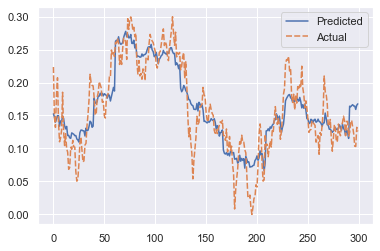

In [13]:
plot(train_prediction, train_actual)
metrics(train_prediction, train_actual)

R-squared: -8.2212
Mean Square Error: 0.4404


(-8.221182853074787, 0.44040602)

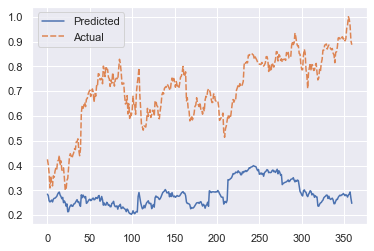

In [16]:
plot(test_prediction, test_actual)
metrics(test_prediction, test_actual)